SOURCE : https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features

In [273]:
import numpy as np
import pandas as pd
import gc
import pickle
import re
import time
import kernel_1 as kn1
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, plot_roc_curve
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, f1_score, fbeta_score, make_scorer, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split #RepeatedStratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import imblearn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [29]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Préparation des données et validation croisée

In [285]:
num_rows = 10000
processed_df = kn1.get_df(debug = True, reload = False, process = True, num_rows=num_rows)
# ligne ajoutée à cause du msg : LightGBMError: Do not support special JSON characters in feature name.
#processed_df = processed_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# ne retient que le jeu dont on connaît la TARGET
processed_df = processed_df[processed_df['TARGET'].notnull()]

# définit les colonnes features qui servent à l'évaluation du modèle
feats = [f for f in processed_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

MODE DEBUG : nb de lignes :  10000
Génère le dataset (process et jointures) puis le sauve
Train samples: 10000, test samples: 10000
Bureau df shape: (2011, 108)
Process bureau and bureau_balance - done in 1s
Previous applications df shape: (9734, 242)
Process previous_applications - done in 1s
Pos-cash balance df shape: (9494, 15)
Process POS-CASH balance - done in 0s
Installments payments df shape: (8893, 26)
Process installments payments - done in 0s
Credit card balance df shape: (9520, 131)
Process credit card balance - done in 0s


In [286]:
y_true = processed_df['TARGET']
X = processed_df #[feats]

In [287]:
# Répartition entre jeu d'entraînement et jeu de validation (2000 lignes)
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=2000, shuffle = False) #random_state=1

In [288]:
X_test[X_test.TARGET==1]

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
8000,8000,109327,1.0,1,0,0,0,112500.0,284400.0,14854.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8018,8018,109351,1.0,1,0,0,0,112500.0,309073.5,26428.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8038,8038,109375,1.0,1,0,1,1,135000.0,454500.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8058,8058,109396,1.0,0,0,0,0,180000.0,1008117.0,32652.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8087,8087,109432,1.0,1,0,0,1,81000.0,225000.0,11250.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9925,9925,111551,1.0,0,1,0,0,225000.0,545040.0,43191.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9930,9930,111557,1.0,0,1,0,0,141750.0,517266.0,28188.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9953,9953,111583,1.0,0,1,0,1,270000.0,755190.0,36459.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9965,9965,111596,1.0,1,0,0,0,63000.0,157500.0,8671.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
X_test.to_csv('processed_df.csv', index= False)

In [289]:
X_train = X_train[feats]
X_test = X_test[feats]

In [290]:
print("Proportion de TARGET = 1 : ", y_true.sum()/y_true.shape[0]*100, " %")

Proportion de TARGET = 1 :  7.75  %


In [291]:
# prépa des folds
nb_folds = 5 #10
strat_fold = StratifiedKFold(n_splits=nb_folds, random_state=1)

# imputation des valeurs manquantes
simple_imputer = SimpleImputer(strategy = 'median') #most_frequent

In [96]:
# définition du modèle avec pondération basée sur le ratio
# 92% de target 0 et 8% de target 1 --> ratio de 1 / 12 environ
weights = {0:1.0, 1:12}

# Définition de la métrique
https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/

https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/

<!-- Recall: Appropriate when minimizing false negatives is the focus.
Comme les faux-négatifs sont plus coûteux, on veut les limiter, donc augmenter la sensibilité (sensitivity ou recall).
On utilisera donc comme métrique : fbeta_score avec un beta > 1, pour favoriser le recall. -->

In [268]:
# définition d'un scorer propre aux règles métier
# def custom_score_function(y_true, y_pred):
    
#     score = 0
#     counter = 1
#     # transforme la Series en array
#     if type(y_true)==pd.Series:
#         y_true = y_true.values
#     if type(y_pred)==pd.Series:
#         y_pred = y_pred.values
        
#     for i in range(len(y_true)):
# #         try:
#         if y_true[i] == 0:
#             # détection d'un vrai négatif (TN)
#             # client SANS défaut de paiement, crédit accordé.
#             # La banque prête 100, récupère 100 + 8 (intérêt) +2 en bonus (l'action monte) -> solde : +10
#             if y_pred[i] == 0: score += 10

#             # détection d'un faux positif (FP)
#             # client SANS défaut de paiement, mais crédit refusé.
#             # La banque ne prête rien, ne gagne pas d'argent alors qu'elle aurait pu  (manque à gagner)
#             # Le CA stagne -> -10 en malus (l'action diminue) -> solde : -10                
#             if y_pred[i] == 1: score += -10 

#         elif y_true[i] == 1:
#             # détection d'un faux négatif (FN)
#             # client AVEC défaut de paiement, crédit accordé mais non remboursé
#             # La banque prête 100, perd 100, -20 en malus (l'action diminue) -> solde : -120               
#             if y_pred[i] == 0: score += -120

#             # détection d'un vrai positif (TP)
#             # client AVEC défaut de paiement, crédit refusé
#             # La banque ne prête rien, ne gagne pas d'argent, mais a su éviter un défaut de paiement. +30 en bonus
#             if y_pred[i] == 1: score += 30
#         counter +=1
# #         except KeyError:
# #             print('KeyError')
# #             continue
#     # retourne au format eval_name eval_result, is_higher_better)        
#     return ('custom_score_function', score/counter, True) #score/counter



In [344]:
def custom_score_function(y_true, y_pred):
    
    # transforme les Series en array
#     if type(y_true)==pd.Series:
#         y_true = y_true.values
#     if type(y_pred)==pd.Series:
#         y_pred = y_pred.values
    
    y_true_ = pd.Series(y_true).astype('int').values
    y_pred_ = pd.Series(y_pred).astype('int').values
    
    counter = len(y_true)
    c_matrix = confusion_matrix(y_true_, y_pred_)
    TN = c_matrix[0,0]
    FN = c_matrix[1,0]
    FP = c_matrix[0,1]
    TP = c_matrix[1,1]        
    score = (10)*TN + (-120)*FN + (-10)*FP + (30)*TP
    # retourne au format eval_name eval_result, is_higher_better)        
    return ('custom_score_function', score/counter, True) #score/counter

my_scorer = make_scorer(custom_score_function, greater_is_better=True)

In [265]:
# chronométrage des temps de calcul des modèles
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - temps de calcul {:.0f}s".format(title, time.time() - t0))

In [43]:
# routine d'évaluation de modèle par validation croisée
def model_eval(model, model_name, X, y):
    with timer("Modèle : {} - dataset : {} lignes".format(model_name, X.shape[0])):
        scores = cross_val_score(model, X, y, scoring=my_scorer, cv=strat_fold, n_jobs=-1)
        print('Validation croisée - Score moyen: {:.3f}'.format(np.mean(scores)))    
    return

# Baseline : régression logistique

In [86]:
# définit le modèle
lr_model = LogisticRegression(solver='lbfgs')

## sans pondération

In [87]:
# Pipeline
lr_steps = [('imputer',simple_imputer), ('logistic', lr_model)]
lr_pipeline = Pipeline(steps=lr_steps)
model_name = "Régression logistique (sans pondération)"

model_eval(lr_pipeline, model_name, X_train, y_train)

Validation croisée - Score moyen: 1.003
Modèle : Régression logistique (sans pondération) - dataset : 8000 lignes - temps de calcul 4s


## avec pondération des classes

In [88]:
wlr_model = LogisticRegression(solver='lbfgs', class_weight=weights)
wlr_steps = [('imputer',simple_imputer), ('w_logistic', wlr_model)]
wlr_pipeline = Pipeline(steps=wlr_steps)
model_name = "Régression logistique (avec pondération)"

In [89]:
model_eval(wlr_pipeline, model_name, X_train, y_train)

Validation croisée - Score moyen: -1.780
Modèle : Régression logistique (avec pondération) - dataset : 8000 lignes - temps de calcul 6s


## avec over sampling

In [116]:
# oversample en précisant le ratio de la classe minoritaire / classe majoritaire
oversample_rate = 0.5
oversample = RandomOverSampler(sampling_strategy=oversample_rate)
#oversample = RandomOverSampler(sampling_strategy="minority")

# exécute le sur-échantillonnage
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
print(Counter(y_over))

Counter({0.0: 7385, 1.0: 3692})


In [113]:
# étapes de SMOTE et undersampling
# smote_ratio = 0.5
# undersampling_ratio = 0.5
# over = SMOTE(sampling_strategy=smote_ratio)
# under = RandomUnderSampler(sampling_strategy=undersampling_ratio)

In [118]:
# pipeline imblearn - VERSION OVERSAMPLE
imb_lr_steps = [('imputer',simple_imputer), ('over', oversample), ('logistic', lr_model)]
imb_lr_pipeline = imblearn.pipeline.Pipeline(steps=imb_lr_steps)
model_name = "Régression logistique (avec over-sampling)"

model_eval(imb_lr_pipeline, model_name, X_train, y_train)

Validation croisée - Score moyen: 0.988
Modèle : Régression logistique (avec over-sampling) - dataset : 8000 lignes - temps de calcul 5s


# Modèle 2 : Random Forest
 Perhaps the most important hyperparameter to tune for the random forest is the number of random features to consider at each split point.
 A good heuristic for classification is to set this hyperparameter to the square root of the number of input features.
 source : https://machinelearningmastery.com/random-forest-ensemble-in-python/

nb de features max pour RF : environ sqrt(765) = 27

In [135]:
# definit le modèle
# hyper-paramètres principaux : max_features, n_estimators,  max_depth
rf_model = RandomForestClassifier(max_features=27, n_estimators=8000, max_depth=8, n_jobs=-1)

## sans pondération

In [136]:
# Pipeline
rf_steps = [('imputer',simple_imputer), ('rf', rf_model)]
rf_pipeline = Pipeline(steps=rf_steps)
model_name = "Forêt aléatoire (sans pondération)"

In [137]:
# mesure performance cross validation
model_eval(rf_pipeline, model_name, X_train, y_train)

Validation croisée - Score moyen: 1.003
Modèle : Forêt aléatoire (sans pondération) - dataset : 8000 lignes - temps de calcul 174s


## avec pondération

In [138]:
wrf_model = RandomForestClassifier(max_features=27, n_estimators=8000, max_depth=8, class_weight=weights, n_jobs=-1)
wrf_steps = [('imputer',simple_imputer), ('wrf', wrf_model)]
wrf_pipeline = Pipeline(steps=wrf_steps)
model_name = "Forêt aléatoire (avec pondération)"

# mesure performance cross validation
model_eval(wrf_pipeline, model_name, X_train, y_train)

Validation croisée - Score moyen: 0.774
Modèle : Forêt aléatoire (avec pondération) - dataset : 8000 lignes - temps de calcul 196s


## avec oversampling

In [139]:
# # Performance sur le jeu d'évaluation
# rf_pipeline.fit(X_train_over, y_train_over)
# y_pred = rf_pipeline.predict(X_test)
# print(custom_score_function(y_test, y_pred))

In [140]:
# pipeline imblearn
imb_rf_steps = [('imputer', simple_imputer), ('over', oversample), ('rf', rf_model)] # ('under', under)
imb_rf_pipeline = imblearn.pipeline.Pipeline(steps=imb_rf_steps)
model_name = "Forêt aléatoire (avec over-sampling)"

# mesure performance cross validation
model_eval(imb_rf_pipeline, model_name, X_train, y_train)

Validation croisée - Score moyen: 1.058
Modèle : Forêt aléatoire (avec over-sampling) - dataset : 8000 lignes - temps de calcul 514s


## Matrice de confusion

In [141]:
# fit sur le jeu d'entraînement
imb_rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('over', RandomOverSampler(sampling_strategy=0.5)),
                ('rf',
                 RandomForestClassifier(max_depth=8, max_features=27,
                                        n_estimators=8000, n_jobs=-1))])

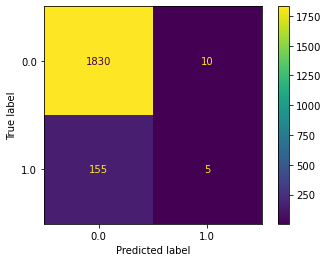

In [142]:
# matrice de confusion sur le jeu de test
plot_confusion_matrix(imb_rf_pipeline, X_test, y_test)
plt.show()

# Modèle 3 : SVM
weighted SVM, or cost-sensitive SVM

https://machinelearningmastery.com/cost-sensitive-svm-for-imbalanced-classification/

In [122]:
svm_model = SVC(gamma='scale')

## sans pondération

In [123]:
# Pipeline
svm_steps = [('imputer',simple_imputer), ('svm', svm_model)]
svm_pipeline = Pipeline(steps=svm_steps)
model_name = "SVC (sans pondération)"

# mesure performance cross validation
model_eval(svm_pipeline, model_name, X_train, y_train)

Validation croisée - Score moyen: 1.003
Modèle : SVC (sans pondération) - dataset : 8000 lignes - temps de calcul 14s


## avec pondération

In [124]:
wsvm_model = SVC(gamma='scale', class_weight=weights) #'balanced')
# Pipeline
wsvm_steps = [('imputer',simple_imputer), ('wsvm', wsvm_model)]
wsvm_pipeline = Pipeline(steps=wsvm_steps)
model_name = "SVC (avec pondération)"

In [125]:
# mesure performance cross validation
model_eval(wsvm_pipeline, model_name, X_train, y_train)

Validation croisée - Score moyen: 1.003
Modèle : SVC (avec pondération) - dataset : 8000 lignes - temps de calcul 87s


## avec oversampling

In [126]:
# pipeline imblearn
imb_svm_steps = [('imputer', simple_imputer), ('over', oversample), ('svm', svm_model)]
imb_svm_pipeline = imblearn.pipeline.Pipeline(steps=imb_svm_steps)
model_name = "SVC (avec over-sampling)"

In [127]:
# mesure performance cross validation
model_eval(imb_svm_pipeline, model_name, X_train, y_train)

Validation croisée - Score moyen: 1.003
Modèle : SVC (avec over-sampling) - dataset : 8000 lignes - temps de calcul 113s


# modèle 4 : LightGBM

## sans pondération

In [58]:
lgbm_model = LGBMClassifier(n_estimators=8000, learning_rate=0.02, num_leaves=34, max_depth=8, n_jobs=-1)
# lgbm_model = LGBMClassifier(n_estimators=997, learning_rate=0.01, num_leaves=32, max_depth=10, n_jobs=-1)
lgbm_steps = [('imputer', simple_imputer), ('lgbm', lgbm_model)]
lgbm_pipeline = Pipeline(steps=lgbm_steps)
model_name = "LightGBM"

In [144]:
# mesure performance cross validation
model_eval(lgbm_pipeline, model_name, X_train, y_train)

Validation croisée - Score moyen: 1.031
Modèle : LightGBM - dataset : 8000 lignes - temps de calcul 144s


## avec pondération

In [301]:
wlgbm_model = LGBMClassifier(is_unbalance=True, n_estimators=8000, learning_rate=0.02, num_leaves=34, max_depth=8, n_jobs=-1)
wlgbm_steps = [('imputer', simple_imputer), ('wlgbm', wlgbm_model)]
wlgbm_pipeline = Pipeline(steps=wlgbm_steps)
model_name = "LightGBM (avec pondération)"

In [146]:
# mesure performance cross validation
model_eval(wlgbm_pipeline, model_name, X_train, y_train)

Validation croisée - Score moyen: 1.128
Modèle : LightGBM (avec pondération) - dataset : 8000 lignes - temps de calcul 187s


## avec oversampling

In [147]:
# pipeline imblearn
imb_lgbm_steps = [('imputer', simple_imputer), ('over', oversample), ('imb_lgbm', lgbm_model)]
imb_lgbm_pipeline = imblearn.pipeline.Pipeline(steps=imb_lgbm_steps)
model_name = "LightGBM (avec oversampling)"

# mesure performance cross validation
model_eval(imb_lgbm_pipeline, model_name, X_train, y_train)

Validation croisée - Score moyen: 1.047
Modèle : LightGBM (avec oversampling) - dataset : 8000 lignes - temps de calcul 181s


## Matrice de confusion

In [148]:
# fit sur le jeu d'entraînement
wlgbm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('wlgbm',
                 LGBMClassifier(is_unbalance=True, learning_rate=0.02,
                                max_depth=8, n_estimators=8000,
                                num_leaves=34))])

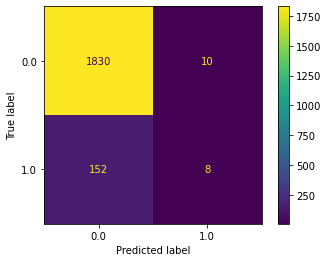

In [149]:
# matrice de confusion sur le jeu de test
plot_confusion_matrix(wlgbm_pipeline, X_test, y_test)
plt.show()

## Optimisation bayesienne des hyperparamètres

In [150]:
from skopt.space import Integer, Real
from skopt.utils import use_named_args
from skopt import gp_minimize

In [153]:
# définit l'espace de recherche des hyperparamètres
# lgbm_model = LGBMClassifier(n_estimators=1000, learning_rate=0.02, num_leaves=34, max_depth=8, n_jobs=-1)
lgbm_hyperparameters = ['n_estimators', 'learning_rate', 'num_leaves', 'max_depth']

lgbm_search_space = [Integer(8000, 11000, name='n_estimators'),
                     Real(0.01, 0.05, name='learning_rate'),
                     Integer(25, 40, name='num_leaves'),
                     Integer(6, 12, name='max_depth')]
model_name = "LightGBM (pondération)"

In [158]:
# définit la fonction utilisée pour évaluer une configuration
@use_named_args(lgbm_search_space)
def evaluate_lgbm_model(**params):
    #    
    lgbm_model = LGBMClassifier(is_unbalance=True, n_jobs=-1)
    lgbm_model.set_params(**params)
    lgbm_steps = [('imputer', simple_imputer), ('lgbm', lgbm_model)]
    lgbm_pipeline = Pipeline(steps=lgbm_steps)    
    # calculate 5-fold cross validation
    result = cross_val_score(lgbm_pipeline, X_train, y_train, cv=strat_fold, n_jobs=-1, scoring=my_scorer)
    # calculate the mean of the scores
    estimate = -np.mean(result)
    return estimate

In [159]:
# perform optimization
with timer("Optimization bayesienne du modèle : {} - dataset : {} lignes".format(model_name, X_train.shape[0])):
    lgbm_result = gp_minimize(func=evaluate_lgbm_model, dimensions=lgbm_search_space, n_calls=10)

Optimization bayesienne du modèle : LightGBM (pondération) - dataset : 8000 lignes - temps de calcul 1476s


In [160]:
print('Meilleur score: {:.2f}'.format(-lgbm_result.fun))
print('Meilleurs hyperparamètres: ')
for i in range(len(lgbm_hyperparameters)):
    print('{} : {:.2f}'.format(lgbm_hyperparameters[i], lgbm_result.x[i]))

Meilleur score: 1.19
Meilleurs hyperparamètres: 
n_estimators : 8874.00
learning_rate : 0.03
num_leaves : 38.00
max_depth : 10.00


## Features importance

In [161]:
data_path = "./data/"

In [161]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    #cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    # best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    df_grp = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].reset_index()
    best_features = df_grp.loc[df_grp.feature.isin(df_grp)]
    label_order = list(df_grp.sort_values("importance", ascending=False)["feature"].values)    
    
    plt.figure(figsize=(8, 10))
    #sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    sns.barplot(x="importance", y="feature", order = label_order, data=df_grp)
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [162]:
feat_importance_df = kn1.kfold_lightgbm(df=processed_df, num_folds=10, submission_file_name="submission_kernel02.csv", 
                                         stratified= False, debug=True)

Starting LightGBM. Train shape: (5000, 744), test shape: (5000, 744)
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.828137	training's binary_logloss: 0.223484	valid_1's auc: 0.759977	valid_1's binary_logloss: 0.217824
[400]	training's auc: 0.861062	training's binary_logloss: 0.208689	valid_1's auc: 0.760042	valid_1's binary_logloss: 0.217424
Early stopping, best iteration is:
[250]	training's auc: 0.838	training's binary_logloss: 0.219184	valid_1's auc: 0.762897	valid_1's binary_logloss: 0.217225
Fold  1 AUC : 0.762897
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.825053	training's binary_logloss: 0.21575	valid_1's auc: 0.769575	valid_1's binary_logloss: 0.297408
Early stopping, best it

In [166]:
feat_importance_df.shape

(7410, 3)

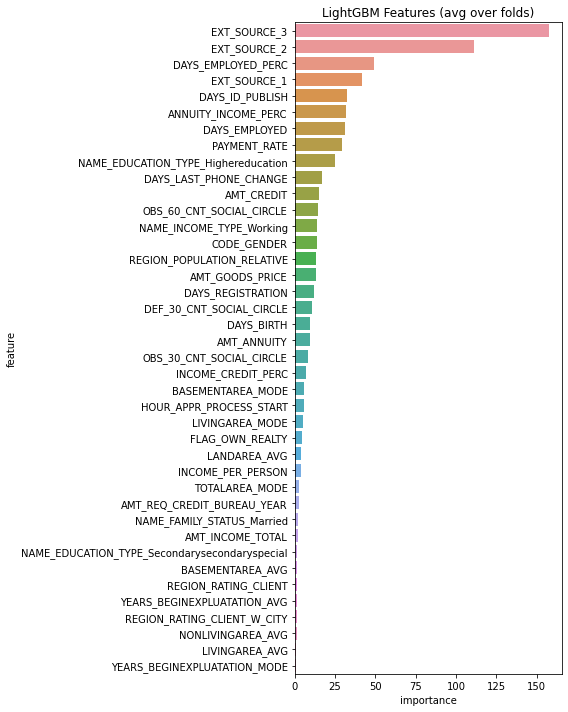

In [167]:
#
display_importances(feat_importance_df)

In [162]:
processed_df_filename = 'processed_df.csv'

# Instantiation et entraînement du modèle LightGBM optimisé

In [165]:
# processed_df

In [336]:
# instance créée à partir des paramètres de l'optimisation bayesienne
lightGBM_clf = LGBMClassifier(is_unbalance=True, n_estimators=8874, learning_rate=0.03, num_leaves=38, max_depth=10, n_jobs=-1)

In [303]:
# lgbm_clf_pipeline = Pipeline( steps=[('imputer', simple_imputer), ('lgbm', lightGBM_clf)] )
# model_name = "LightGBM (avec pondération)"

In [342]:
y_test.astype('int')

8000    1
8001    0
8002    0
8003    0
8004    0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: TARGET, Length: 2000, dtype: int32

In [350]:
# entrainement sur le train set
with timer("Entrainement du modèle : {} - sur le train set de : {} lignes".format(model_name, X_train.shape[0])):
    lightGBM_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric="auc", early_stopping_rounds= 1000, verbose=100) #"auc" custom_score_function, early_stopping_rounds= 200
    #lightGBM_clf.fit(X_train, y_train, eval_metric="custom_score_function", verbose=100) #"auc" custom_score_function, early_stopping_rounds= 200
    

Training until validation scores don't improve for 1000 rounds
[100]	valid_0's auc: 0.746647	valid_0's binary_logloss: 0.378231
[200]	valid_0's auc: 0.754022	valid_0's binary_logloss: 0.332857
[300]	valid_0's auc: 0.756922	valid_0's binary_logloss: 0.295381
[400]	valid_0's auc: 0.755041	valid_0's binary_logloss: 0.274445
[500]	valid_0's auc: 0.752719	valid_0's binary_logloss: 0.264816
[600]	valid_0's auc: 0.749311	valid_0's binary_logloss: 0.262545
[700]	valid_0's auc: 0.74607	valid_0's binary_logloss: 0.265081
[800]	valid_0's auc: 0.746211	valid_0's binary_logloss: 0.270622
[900]	valid_0's auc: 0.747003	valid_0's binary_logloss: 0.277517
[1000]	valid_0's auc: 0.745679	valid_0's binary_logloss: 0.287248
[1100]	valid_0's auc: 0.745693	valid_0's binary_logloss: 0.298212
[1200]	valid_0's auc: 0.746135	valid_0's binary_logloss: 0.310255
Early stopping, best iteration is:
[288]	valid_0's auc: 0.757858	valid_0's binary_logloss: 0.299078
Entrainement du modèle : LightGBM (avec pondération) - 

In [357]:
# sauve le modèle entraîné
with open("lightGBM_trained_model", "wb") as output_file:
    pickle.dump(lightGBM_clf, output_file)

In [5]:
# charge le modèle entraîné
with open("lightGBM_trained_model", "rb") as input_file:
    lightGBM_clf = pickle.load(input_file)

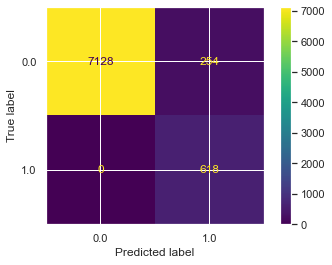

In [351]:
plot_confusion_matrix(lightGBM_clf, X_train, y_train)
plt.show()

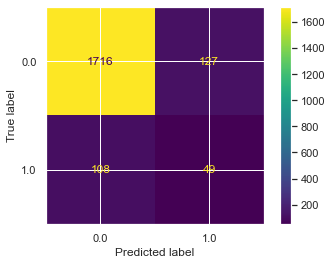

In [352]:
plot_confusion_matrix(lightGBM_clf, X_test, y_test)
plt.show()

## Interprétabilité du modèle avec SHAP

In [81]:
import shap
# load JS visualization code to notebook
shap.initjs()

In [373]:
# Crée les objets shap et les sauve (seront ensuite rechargés par le dashboard)
shap_explainer = shap.TreeExplainer(lightGBM_clf)
shap_values = shap_explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [360]:
# sauve les SHAP pour utilisation dans le dashboard
with open("shap_objects", "wb") as output_file:
    pickle.dump(shap_explainer, output_file)
    pickle.dump(shap_values, output_file)

In [116]:
with open("shap_objects", "rb") as input_file:
    shap_explainer = pickle.load(input_file)
    shap_values = pickle.load(input_file)

In [375]:
X_test

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
8000,1,0,0,0,112500.0,284400.0,14854.5,225000.0,0.006008,-23274,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8001,1,0,1,1,81000.0,450000.0,14373.0,450000.0,0.018209,-12901,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8002,0,0,0,0,216000.0,804420.0,38830.5,706500.0,0.018850,-10396,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8003,1,0,0,1,144000.0,1256400.0,40657.5,900000.0,0.024610,-17258,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8004,0,1,0,0,157500.0,270000.0,13500.0,270000.0,0.072508,-10430,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,1,0,1,135000.0,270000.0,13500.0,270000.0,0.019689,-11454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,1,1,0,0,166500.0,1006920.0,51543.0,900000.0,0.025164,-16480,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,0,1,0,0,225000.0,497520.0,53581.5,450000.0,0.019689,-15479,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,1,0,1,0,360000.0,348264.0,27643.5,315000.0,0.018801,-15939,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [376]:
X_test.loc[8000,:]

CODE_GENDER                              1.0
FLAG_OWN_CAR                             0.0
FLAG_OWN_REALTY                          0.0
CNT_CHILDREN                             0.0
AMT_INCOME_TOTAL                    112500.0
                                      ...   
CC_NAME_CONTRACT_STATUS_nan_MAX          NaN
CC_NAME_CONTRACT_STATUS_nan_MEAN         NaN
CC_NAME_CONTRACT_STATUS_nan_SUM          NaN
CC_NAME_CONTRACT_STATUS_nan_VAR          NaN
CC_COUNT                                 NaN
Name: 8000, Length: 765, dtype: float64

In [379]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
id_cust_ = 0
# shap.force_plot(shap_explainer.expected_value[1], shap_values[1][id_cust_,:], X_train.iloc[0,:])

shap.force_plot(shap_explainer.expected_value[1], shap_values[0][1000,:], X_test.iloc[0,:])

In [128]:
sk_id = 100003
train_df[ train_df.SK_ID_CURR==sk_id].index

Int64Index([1], dtype='int64')

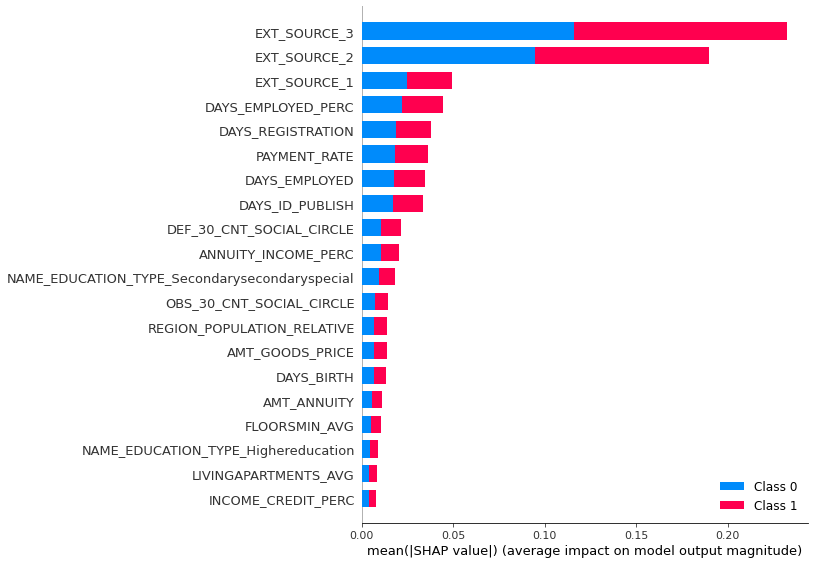

In [83]:
ax_1 = shap.summary_plot(shap_values, X_train)

## Détermination du meilleur seuil

In [102]:
sns.set_context("notebook")
sns.set_style("darkgrid")    

In [353]:
def find_best_threshold(my_X, my_y_true, model):    
    # prédiction de la classe 1
    y_pred_proba = model.predict_proba(my_X, num_iteration=model.best_iteration_)[:,1] # 
    # thresh = 0.05
    start_thresh = 0.001 # 0.001
    step = 0.01 #0.02
    score_list, thresh_list = [], []
    for thresh in np.arange(start_thresh,1,step):
        y_pred = np.zeros(len(my_y_true))
        # classe les proba > seuil dans la classe '1'
        super_threshold_indices = y_pred_proba > thresh
        y_pred[super_threshold_indices] = 1
        # calcule le score
        _, score, _ = custom_score_function(my_y_true, y_pred)
        # print('thresh : ', thresh, ' - ',score)
        score_list.append(score)
        thresh_list.append(thresh)
    #graphe
    fig, ax = plt.subplots(1,1, figsize=(25,7))
    data=pd.DataFrame({'seuil':thresh_list, 'score':score_list})
    g = sns.lineplot(data=data, x='seuil', y='score', marker='o', dashes=False, ax=ax)    
    plt.show()
    return thresh_list, score_list

In [330]:
y_pred_proba = lightGBM_clf.predict_proba(X_test)[:,1] #, num_iteration=lightGBM_clf.best_iteration_

In [325]:
y_pred_proba.shape

(2000,)

In [331]:
y_pred_proba

array([5.19423526e-08, 3.61097900e-07, 7.80001590e-05, ...,
       1.87951804e-02, 6.94554574e-02, 1.23591019e-01])

In [354]:
# Utilisation du jeu de test
lightGBM_clf.predict_proba(X_test)

array([[0.96123475, 0.03876525],
       [0.92820562, 0.07179438],
       [0.66399242, 0.33600758],
       ...,
       [0.55193878, 0.44806122],
       [0.31605668, 0.68394332],
       [0.10788926, 0.89211074]])

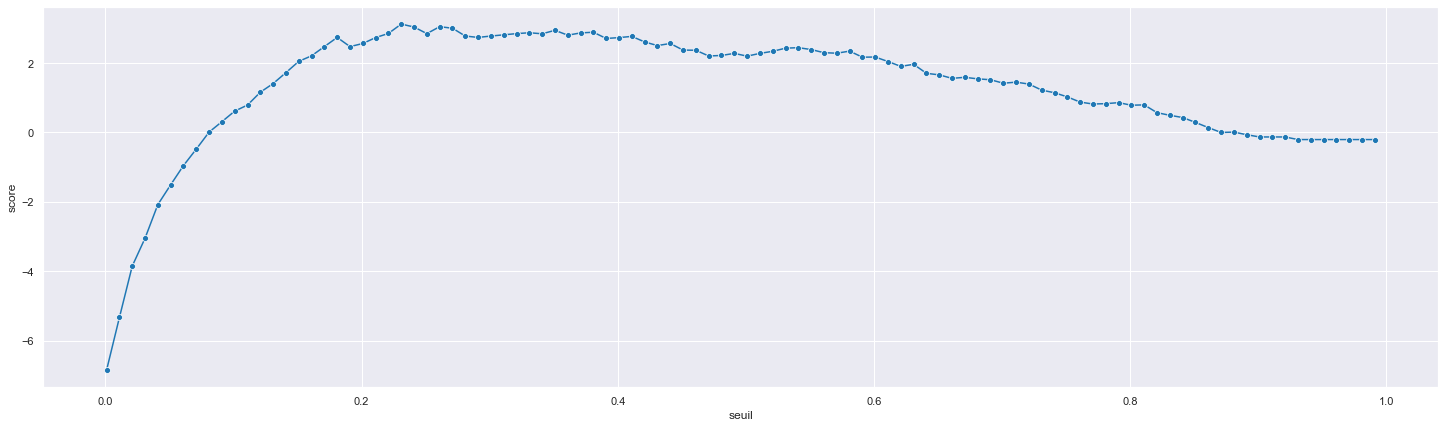

In [355]:
thresh_list_, score_list_ = find_best_threshold(X_test, y_test.values, lightGBM_clf) # X_test, y_test

In [356]:
print('Meilleur score : {}\nSeuil correspondant : {}'.format(np.max(score_list_), thresh_list_[np.argmax(score_list_)]))

Meilleur score : 3.125
Seuil correspondant : 0.23099999999999996


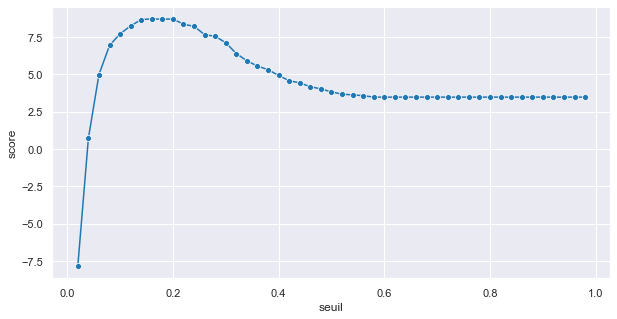

In [159]:
thresh_list_, score_list_ = find_best_threshold(X_train, y, lightGBM_clf)

In [160]:
print('Meilleur score : {}\nSeuil correspondant : {}'.format(np.max(score_list_), thresh_list_[np.argmax(score_list_)]))

Meilleur score : 8.71064467766117
Seuil correspondant : 0.16


## prépa du DF utilisé pour l'affichage dashboard

In [40]:
X_test

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
9953,0,1,0,1,270000.0,755190.0,36459.0,675000.0,0.020246,-13940,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3850,0,0,0,0,112500.0,765000.0,39190.5,765000.0,0.026392,-16751,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4962,1,0,0,2,67500.0,509602.5,22576.5,387000.0,0.006852,-11156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3886,1,1,1,0,90000.0,684000.0,19998.0,684000.0,0.031329,-17719,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5437,1,0,0,1,112500.0,187704.0,14958.0,148500.0,0.018209,-11117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919,0,1,1,0,67500.0,481495.5,33511.5,454500.0,0.031329,-22629,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162,1,0,0,0,112500.0,544491.0,17563.5,454500.0,0.030755,-21819,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7903,1,1,0,0,112500.0,180000.0,9000.0,180000.0,0.014520,-8263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2242,1,0,1,0,112500.0,959598.0,28188.0,801000.0,0.004849,-21083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [227]:
raw_df = kn1.get_df(debug=True, reload=False, process=False, num_rows=num_rows)

MODE DEBUG : nb de lignes :  10000
Retourne df non traité 



In [228]:
# NaN values for DAYS_EMPLOYED: 365.243 -> nan
raw_df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

In [229]:
import dashboard1_var as dsh

In [230]:
display_df = raw_df.iloc[8000:10000].copy()

In [231]:
# conversion des jours en année
for col in dsh.type_var[dsh.DAYS]:
    display_df[ col ] = -display_df[col] / 365

In [232]:
display_df[dsh.CREDIT_GRANT] = display_df['TARGET'].apply(lambda x: 'favorable' if x == 0 else 'not favorable')

In [236]:
display_df[ display_df.SK_ID_CURR==111551 ]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Credit grant
9925,111551,1,Cash loans,M,Y,Y,0,225000.0,545040.0,43191.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,not favorable


In [237]:
display_df.to_csv('display_df.csv', index= False)

In [140]:
# display_df

In [238]:
# dictionnaire des MIN et MAX pour chaque variable éditable
min_var, max_var = {}, {}
for var_name in dsh.editable_var:
    min_var[var_name] = float(display_df[var_name].min())
    max_var[var_name] = float(display_df[var_name].max())

# sauve dans un fichier
with open("min_max_feats", "wb") as output_file:
    pickle.dump(min_var, output_file)
    pickle.dump(max_var, output_file)
    pickle.dump(feats, output_file)

In [7]:
# recharge les dictionnaires des MIN et MAX
min_var, max_var = {}, {}
with open("min_max_feats", "rb") as input_file:
    min_var = pickle.load(input_file)
    max_var = pickle.load(input_file)
    feats = pickle.load(input_file)

## Courbe ROC

In [22]:
# source : https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
def display_roc_curve():
    tprs = []
    aucs = []
    gmeans_set, thresholds_set = [], []
    mean_fpr = np.linspace(0, 1, 100) 
    fig, ax = plt.subplots(figsize=(10,10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        lightGBM_clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose=0, early_stopping_rounds= 200)
        
        # ROC curve
        my_roc_curve = plot_roc_curve(lightGBM_clf, valid_x, valid_y,
                             name='ROC fold {}'.format(n_fold),
                             alpha=0.3, lw=1, ax=ax)        
        
        interp_tpr = np.interp(mean_fpr, my_roc_curve.fpr, my_roc_curve.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(my_roc_curve.roc_auc)
        
        # predict probabilities
        y_pred = lightGBM_clf.predict_proba(valid_x)
        # keep probabilities for the positive outcome only
        y_pred = y_pred[:, 1]        
        fpr, tpr, thresholds = roc_curve(valid_y, y_pred)
        # calculate the g-mean for each threshold
        gmeans = np.sqrt(tpr * (1-fpr))
        # locate the index of the largest g-mean
        ix = np.argmax(gmeans)
        # print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
        gmeans_set.append(gmeans[ix])
        thresholds_set.append(thresholds[ix])
        

    # Courbe ROC
    # trace la diagonale (classifieur naif)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    # trace la courbe moyenne
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    # cherche la meilleure moyenne géométrique sur la courbe moyenne
    gmeans = np.sqrt(mean_tpr * (1-mean_fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('meilleure moyenne géométrique sur la courbe moyenne : ',gmeans[ix])
    ax.scatter(mean_fpr[ix], mean_tpr[ix], marker='o', color='black', label='Best')    
    
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="LightGBM Classifier")
    ax.legend(loc="lower right")
    plt.show()
    
    print('Seuil moyen={}, Moyenne géométrique moyenne ={}'.format(np.mean(thresholds_set), np.mean(gmeans_set)))
    return

meilleure moyenne géométrique sur la courbe moyenne :  0.692732676021154


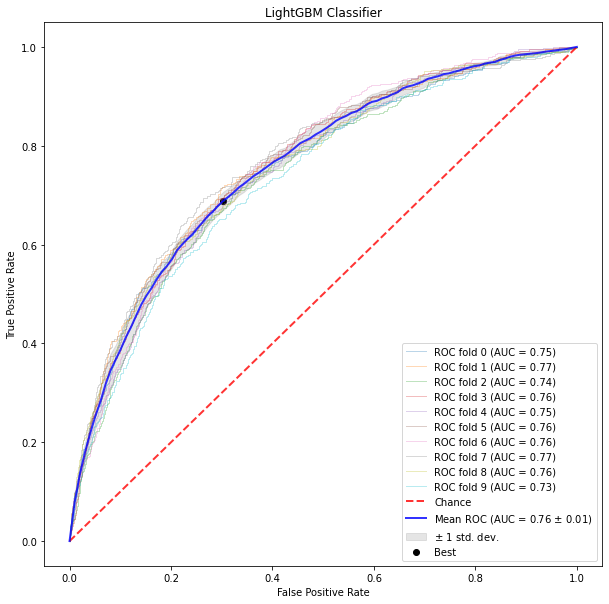

Seuil moyen=0.0794563046377312, Moyenne géométrique moyenne =0.6964655014811014


In [23]:
display_roc_curve()

In [195]:
# source : https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
# def compute_pr_curve():  
#     precs = []
#     mean_recall = np.linspace(0, 1, 100)
#     mean_prec = []
#     fig, ax = plt.subplots(figsize=(10,10))
#     for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
#         train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
#         valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

#         lightGBM_clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
#             eval_metric= 'auc', verbose=0, early_stopping_rounds= 200)

#         # predict probabilities
#         y_pred = lightGBM_clf.predict_proba(valid_x)
#         # keep probabilities for the positive outcome only
#         y_pred = y_pred[:, 1]

#         # PR curve
#         pr_curve = plot_precision_recall_curve(lightGBM_clf, valid_x, valid_y,
#                              name='PR fold {}'.format(n_fold),
#                              alpha=0.3, lw=1, ax=ax)  
        
#         interp_prec = np.interp(mean_recall, pr_curve.recall, pr_curve.precision)
#         interp_prec[0] = 1.0
#         #print('interp_prec : ', interp_prec)
#         precs.append(interp_prec)

#         #aucs.append(roc_curve.roc_auc)

#         # calcule meilleure f-measure et threshold
#         precision, recall, pr_thresholds = precision_recall_curve(valid_y, y_pred)

#         precision = precision[:-10]
#         recall = recall[:-10]
#         pr_thresholds = pr_thresholds[:-10]
#         # convert to f score
#         fscore = (2 * precision * recall) / (precision + recall)
#         # locate the index of the largest f score
#         ix = np.argmax(fscore)
#         print('ix : ', ix)
#         print('pr_curve - Best Threshold=%f, F-Score=%.3f' % (pr_thresholds[ix], fscore[ix]))
        
#     # trace la courbe moyenne
# #     mean_prec = np.mean(precs, axis=0)
# #     #mean_prec[-1] = 0.0
# #     ax.plot(mean_recall, mean_prec, color='b',
# #             #label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
# #             lw=2, alpha=.8)
#     plt.show()
#     return

In [221]:
# predict probabilities
y_pred = lightGBM_clf.predict_proba(train_df[feats], num_iteration=lightGBM_clf.best_iteration_)
# keep probabilities for the positive outcome only
y_pred = y_pred[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(train_df['TARGET'], y_pred)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.087427, G-Mean=0.746


## Test sur un individu

In [403]:
# Test sur un individu
test_df = pd.read_csv('processed_df.csv', nrows= num_rows)
SK_ID_CURR_TEST = 109327 #100002
my_cust = test_df[ test_df.SK_ID_CURR == SK_ID_CURR_TEST].copy()

In [366]:
my_cust['EXT_SOURCE_3']

8000    0.758393
Name: EXT_SOURCE_3, dtype: float64

In [225]:
# for var_name in dsh.editable_var: #:
#     print(var_name)
#     my_cust[var_name] = 10 #user_var[var_name]
my_cust['DAYS_EMPLOYED_PERC'] = 0.1
# my_cust['EXT_SOURCE_1'] = 0
# my_cust['EXT_SOURCE_2'] = 0
# my_cust['EXT_SOURCE_3'] = 0

In [363]:
my_cust

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
8000,8000,109327,1.0,1,0,0,0,112500.0,284400.0,14854.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [261]:
# PREDICTION PROBA
# [0] : sélectionne la première ligne (DF n'a qu'une ligne de toutes façons)
# [1] : proba de la classe 1
print('proba : ',lightGBM_clf.predict_proba(my_cust[feats], num_iteration=lightGBM_clf.best_iteration_)[0][1])

# PREDICTION CLASSE
print('classe : ',lightGBM_clf.predict(my_cust[feats], num_iteration=lightGBM_clf.best_iteration_)[0])

proba :  0.1002078904321942
classe :  0.0


In [404]:
test_df

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,8000,109327,1.0,1,0,0,0,112500.0,284400.0,14854.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8001,109329,0.0,1,0,1,1,81000.0,450000.0,14373.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8002,109330,0.0,0,0,0,0,216000.0,804420.0,38830.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8003,109331,0.0,1,0,0,1,144000.0,1256400.0,40657.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8004,109332,0.0,0,1,0,0,157500.0,270000.0,13500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,9995,111629,0.0,1,1,0,1,135000.0,270000.0,13500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,9996,111630,0.0,1,1,0,0,166500.0,1006920.0,51543.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,9997,111631,0.0,0,1,0,0,225000.0,497520.0,53581.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,9998,111632,0.0,1,0,1,0,360000.0,348264.0,27643.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [409]:
SK_ID_CURR_TEST = 109327
test_df[ test_df.SK_ID_CURR == SK_ID_CURR_TEST].index

#test_df.index.get_loc(8000)

Int64Index([0], dtype='int64')

In [400]:
processed_df

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,111629,0.0,1,1,0,1,135000.0,270000.0,13500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,9996,111630,0.0,1,1,0,0,166500.0,1006920.0,51543.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,9997,111631,0.0,0,1,0,0,225000.0,497520.0,53581.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,9998,111632,0.0,1,0,1,0,360000.0,348264.0,27643.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


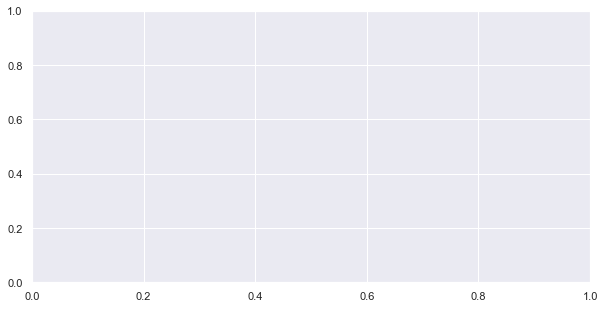

In [381]:

fig_1, ax_1 = plt.subplots(1,1, figsize=(10,5))    
shap.force_plot( shap_explainer.expected_value[1], shap_values[0][client_idx,:], processed_df[feats].iloc[0,:],
                link='logit', figsize=(12,3) )

## Tests visualisation

In [ ]:
# df = process_df(debug=True)

In [265]:
sns.set_context("notebook")
sns.set_style("darkgrid")    

In [15]:
# Suppression valeurs extrêmes
var_label= 'AMT_CREDIT' #'AMT_ANNUITY'# 'AMT_INCOME_TOTAL' #'AMT_GOODS_PRICE' #'AMT_ANNUITY' EXT_SOURCE_1

In [16]:
train_df[var_label].values

array([ 406597.5, 1293502.5,  135000. , ...,  497520. ,  348264. ,
        355536. ])

In [ ]:
np.nanpercentile(train_df[var_label].values, 25)

In [ ]:
# calculate interquartile range
q25, q75 = np.nanpercentile(train_df[var_label].values, 25), np.nanpercentile(train_df[var_label].values, 75)
iqr = q75 - q25
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

In [ ]:
# remove outliers
# df = df.drop( df[ (df.score < 50) & (df.score > 20) ].index)
df_outliers_removed = train_df[ (train_df[var_label] >= lower) &  (train_df[var_label] <= upper) ]

### Histogrammes

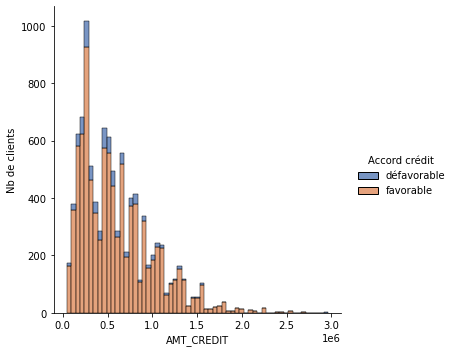

In [19]:
#fig, ax = plt.subplots(1,1, figsize=(6,6))
#g = sns.distplot(outliers_removed, kde=False, color='k')
g = sns.displot(data=train_df, x=var_label, hue="Accord crédit", multiple="stack", palette="deep")
# g = sns.displot(data=df_outliers_removed, x=var_label)
g.set(xlabel = var_label, ylabel = "Nb de clients")
plt.show(g)

In [20]:
df_outliers_removed['TARGET'].isnull().sum()

NameError: name 'df_outliers_removed' is not defined

In [ ]:
df_outliers_removed.describe()

### BOXPLOTS

In [ ]:
g = sns.boxplot(data=train_df, x='DAYS_BIRTH', y='Accord crédit')
plt.show(g)

In [ ]:
df_outliers_removed['TARGET'].isnull().sum()

In [ ]:
# DF train d'origine (avec OH encoding et jointures)
app_train_df = pd.read_csv(data_path+'application_train.csv')

In [ ]:
raw_df = application_train_test(10000)

In [23]:
processed_customer_df = processed_df[ processed_df.SK_ID_CURR == SK_ID_CURR_TEST].copy()

In [25]:
processed_customer_df[var_label]

0    406597.5
Name: AMT_CREDIT, dtype: float64

In [26]:
import dashboard1_var as dsh

In [28]:
dsh.cust_var['INCOME_OCCUPATION'].keys()

dict_keys(['NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED'])

In [51]:
cust_value = raw_df['AMT_INCOME_TOTAL'].values[0]